In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import model_selection
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sb
import math
import time as t

In [110]:
df = pd.read_csv(r'boston_house_prices.csv', skiprows = 1)
df = df.drop(columns=['CHAS'])
print(df.shape)

dup_indx = df.duplicated()
df = df[dup_indx==False]
print(df.shape)

na_indx = df.index.to_frame().isna().any(axis=1)
df = df[na_indx==False]
print(df.shape)

z_score = st.zscore(df.drop(columns=['MEDV']))
filtered = (np.abs(z_score)< 3).all(axis=1)
print(df[filtered==False].head())
df = df[filtered].reset_index(drop=True)
print(df.shape)

(506, 13)
(506, 13)
(506, 13)
        CRIM     ZN  INDUS    NOX     RM    AGE     DIS  RAD  TAX  PTRATIO  \
55   0.01311   90.0   1.22  0.403  7.249   21.9  8.6966    5  226     17.9   
56   0.02055   85.0   0.74  0.410  6.383   35.7  9.1876    2  313     17.3   
57   0.01432  100.0   1.32  0.411  6.816   40.5  8.3248    5  256     15.1   
102  0.22876    0.0   8.56  0.520  6.405   85.4  2.7147    5  384     20.9   
141  1.62864    0.0  21.89  0.624  5.019  100.0  1.4394    4  437     21.2   

          B  LSTAT  MEDV  
55   395.93   4.81  35.4  
56   396.90   5.77  24.7  
57   392.90   3.95  31.6  
102   70.80  10.63  18.6  
141  396.90  34.41  14.4  
(448, 13)


In [111]:
def correlation(df, target_name):
    drop=[]
    corr_matrix = df.corr()
    corr_target = pd.Series(dtype='float64')
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.columns[i] == target_name) and (corr_matrix.columns[j] != target_name):
                corr_target[corr_matrix.columns[j]] = corr_matrix.iloc[i,j]
                if (np.abs(corr_matrix.iloc[i,j]) <= 0.2) and (corr_matrix.columns[j] not in drop):
                    print(corr_matrix.columns[j], 'has LOW CORRELATION with TARGET')
                    drop.append(corr_matrix.columns[j])

            if (np.abs(corr_matrix.iloc[i,j]) >= 0.8) and (corr_matrix.columns[j] not in drop):
                print(corr_matrix.columns[i], '&', corr_matrix.columns[j], 'have HIGH CORRELATION')
                drop.append(corr_matrix.columns[j])
    corr_target = corr_target.sort_values(key =np.abs, ascending = False)
    print(corr_target)
    
    return drop, corr_target

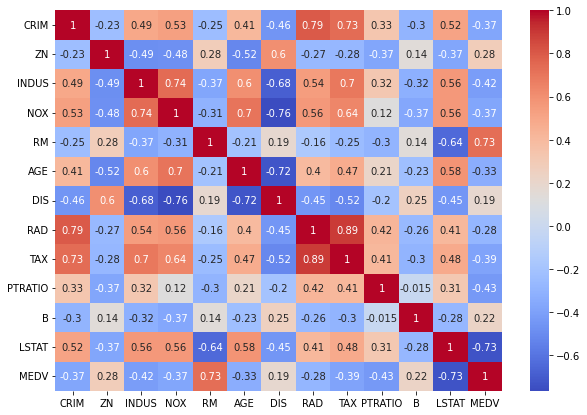

TAX & RAD have HIGH CORRELATION
DIS has LOW CORRELATION with TARGET
LSTAT     -0.732067
RM         0.730551
PTRATIO   -0.434014
INDUS     -0.419162
TAX       -0.386782
NOX       -0.374943
CRIM      -0.373811
AGE       -0.331293
RAD       -0.284681
ZN         0.278847
B          0.224137
DIS        0.186636
dtype: float64
['RAD', 'DIS']


In [112]:
plt.figure(figsize=(10,7))
dataplot_feature = sb.heatmap(df.corr(), cmap='coolwarm', annot=True)

plt.show()
to_drop, corr_target = correlation(df, 'MEDV')
print(to_drop)

df = df.drop(columns=to_drop)
corr_target = corr_target.drop(to_drop)

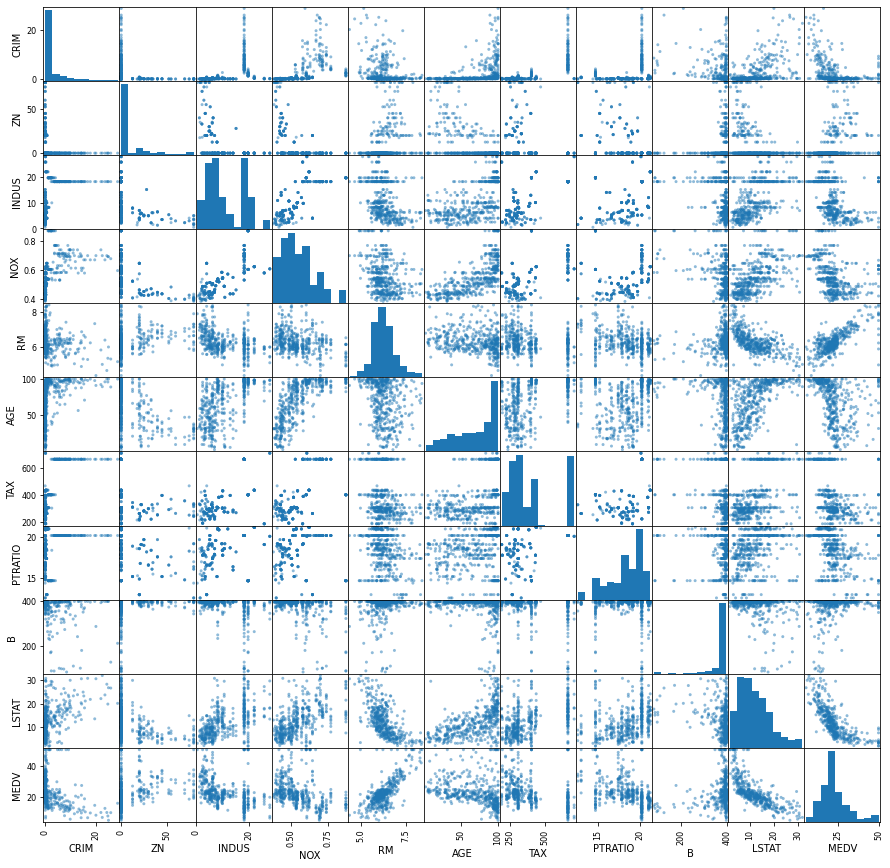

In [113]:
pd.plotting.scatter_matrix(df, figsize=(15,15))
plt.show()

In [114]:
features = df.drop(columns=['MEDV'])
targets = df['MEDV']
train_X, test_X, train_Y, test_Y = train_test_split(features, targets, test_size=0.2, train_size=0.8, random_state=42)
train_X = train_X.reset_index(drop=True)
test_X = test_X.reset_index(drop=True)
train_Y = train_Y.reset_index(drop=True)
test_Y = test_Y.reset_index(drop=True)

print(len(train_X))
print(len(test_X))
kfolds = model_selection.KFold(n_splits=5, shuffle=True, random_state = 42)

358
90


## __Model Evaluation__

In [115]:
def MeanSquareError(predicted, test_Y):
    result_df = test_Y.sub(predicted)
    result_df = result_df.mul(result_df)
    result = result_df.sum()
    result = result/len(predicted)
    return result

In [116]:
def RootMeanSquareError(predicted, test_Y):
    return math.sqrt(MeanSquareError(predicted, test_Y))

In [117]:
def AdjustedRSquare(predicted, test_Y, num_var):
    R2 = r2_score(test_Y, predicted)
    return 1-R2*((len(test_Y)-1)/(len(test_Y)-num_var-1))

## __Multiple Regression__

In [118]:
def predict_MultipleRegression(trainX, trainY, testX):
    linear_reg = LinearRegression().fit(trainX, trainY)
    return pd.Series(linear_reg.predict(testX)), linear_reg

In [119]:
print(corr_target)

LSTAT     -0.732067
RM         0.730551
PTRATIO   -0.434014
INDUS     -0.419162
TAX       -0.386782
NOX       -0.374943
CRIM      -0.373811
AGE       -0.331293
ZN         0.278847
B          0.224137
dtype: float64


In [120]:
num_features = 3
evaluation = pd.DataFrame(columns = ['Independent Variables', 'RMSE', 'Adjusted R_Square'])
while num_features <= len(corr_target):
    features = corr_target[:num_features].index
    curr_train_X = train_X[features]
    curr_test_X = test_X[features]
    score_r2 = model_selection.cross_val_score(LinearRegression(), curr_train_X, train_Y, cv=kfolds, scoring='r2')
    score_mse = model_selection.cross_val_score(LinearRegression(), curr_train_X, train_Y, cv=kfolds, scoring='neg_mean_squared_error')
    evaluation.loc[len(evaluation.index)] = [num_features, 
                                             math.sqrt(np.abs(score_mse.mean())), 
                                             1-score_r2.mean()*((len(test_Y)-1)/(len(test_Y)-num_features-1))]
    num_features = num_features + 1
print(evaluation)

   Independent Variables      RMSE  Adjusted R_Square
0                    3.0  4.979621           0.321240
1                    4.0  4.996740           0.315545
2                    5.0  4.992130           0.307400
3                    6.0  5.000984           0.300373
4                    7.0  5.051402           0.299149
5                    8.0  5.088438           0.296593
6                    9.0  5.058452           0.283423
7                   10.0  5.028207           0.269641


In [121]:
features = corr_target[:3].index
curr_train_X = train_X[features]
curr_test_X = test_X[features]

start = t.time()
predicted, reg = predict_MultipleRegression(curr_train_X, train_Y, curr_test_X)
mul_reg_t = t.time() - start
print('Time =', mul_reg_t, 's')
print('RMSE=',RootMeanSquareError(predicted, test_Y))
print('Adjusted R Squared=',AdjustedRSquare(predicted, test_Y, 5))
print('B0 =', reg.intercept_)
print('B1 =', reg.coef_[0], ',', curr_train_X.columns[0])
print('B2 =', reg.coef_[1], ',', curr_train_X.columns[1])
print('B3 =', reg.coef_[2], ',', curr_train_X.columns[2])

Time = 0.0030241012573242188 s
RMSE= 4.418847556695765
Adjusted R Squared= 0.3015157392574175
B0 = 7.8296292266721075
B1 = -0.5306818262697807 , LSTAT
B2 = 5.642013069924316 , RM
B3 = -0.7512865305830854 , PTRATIO


#### Residual Plot 

LSTAT vs MEDV

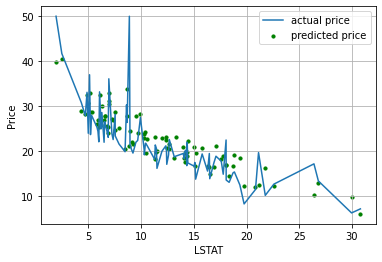

In [122]:
sorted_inds = np.argsort(curr_test_X.LSTAT)
sorted_by_LSTAT = curr_test_X.loc[sorted_inds]
sorted_predicted = predicted.loc[sorted_inds]
sorted_actual = test_Y.loc[sorted_inds]

plt.scatter(sorted_by_LSTAT['LSTAT'], sorted_predicted, label='predicted price', color='green', s = 10)
plt.plot(sorted_by_LSTAT['LSTAT'], sorted_actual, label='actual price')
plt.ylabel('Price')
plt.xlabel('LSTAT')
plt.grid(True)
plt.legend()
plt.show()

RM vs MEDV

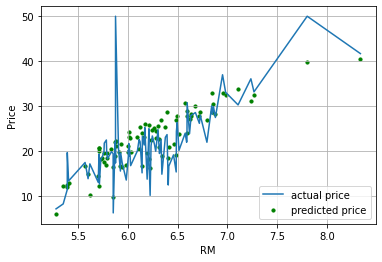

In [123]:
sorted_inds = np.argsort(curr_test_X.RM)
sorted_by_RM = curr_test_X.loc[sorted_inds]
sorted_predicted = predicted.loc[sorted_inds]
sorted_actual = test_Y.loc[sorted_inds]

plt.scatter(sorted_by_RM['RM'], sorted_predicted, label='predicted price', color='green', s = 10)
plt.plot(sorted_by_RM['RM'], sorted_actual, label='actual price')
plt.ylabel('Price')
plt.xlabel('RM')
plt.grid(True)
plt.legend()
plt.show()

PTRATIO vs MEDV

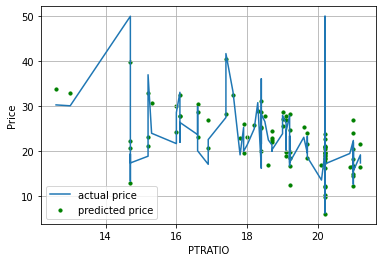

In [124]:
sorted_inds = np.argsort(curr_test_X.PTRATIO)
sorted_by_PTRATIO = curr_test_X.loc[sorted_inds]
sorted_predicted = predicted.loc[sorted_inds]
sorted_actual = test_Y.loc[sorted_inds]

plt.scatter(sorted_by_PTRATIO['PTRATIO'], sorted_predicted, label='predicted price', color='green', s = 10)
plt.plot(sorted_by_PTRATIO['PTRATIO'], sorted_actual, label='actual price')
plt.ylabel('Price')
plt.xlabel('PTRATIO')
plt.grid(True)
plt.legend()
plt.show()

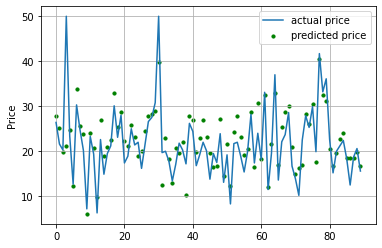

In [125]:
plt.scatter(curr_test_X.index,predicted, label='predicted price', color='green', s = 10)
plt.plot(test_Y, label='actual price')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

## __Decision Tree Regressor__

In [126]:
def predict_DTRegressor(trainX, trainY, testX, depth):
    DT_reg = DecisionTreeRegressor(random_state = 42, max_depth = depth).fit(trainX, trainY)
    return pd.Series(DT_reg.predict(testX)), DT_reg

In [127]:
num_features = 3
evaluation = pd.DataFrame(columns = ['Independent Variables', 'Best Max Depth', 'RMSE', 'Adjusted R_Square'])
while num_features <= len(corr_target):
    features = corr_target[:num_features].index
    curr_train_X = train_X[features]
    curr_test_X = test_X[features]
    rmse = []
    depth = 2
    while depth <= (len(curr_train_X)-1):
        score = model_selection.cross_val_score(DecisionTreeRegressor(random_state=42, max_depth = depth), curr_train_X, train_Y, cv=kfolds, scoring='neg_mean_squared_error')
        rmse.append(math.sqrt(np.abs(score.mean())))
        depth = depth+1
    best_depth = np.argmin(rmse)+2
    
    score_r2 = model_selection.cross_val_score(DecisionTreeRegressor(random_state=42, max_depth = depth), curr_train_X, train_Y, cv=kfolds, scoring='r2')
    score_mse = model_selection.cross_val_score(DecisionTreeRegressor(random_state=42, max_depth = depth), curr_train_X, train_Y, cv=kfolds, scoring='neg_mean_squared_error')
    evaluation.loc[len(evaluation.index)] = [num_features,
                                             best_depth,
                                             math.sqrt(np.abs(score_mse.mean())), 
                                             1-score_r2.mean()*((len(test_Y)-1)/(len(test_Y)-num_features-1))]
    num_features = num_features + 1
print(evaluation)

   Independent Variables  Best Max Depth      RMSE  Adjusted R_Square
0                    3.0             4.0  5.471445           0.402070
1                    4.0             4.0  5.560370           0.410371
2                    5.0             4.0  5.114754           0.330285
3                    6.0             3.0  5.391132           0.363929
4                    7.0             4.0  5.173926           0.322540
5                    8.0             4.0  5.288409           0.338178
6                    9.0             4.0  5.290654           0.330902
7                   10.0             4.0  5.376869           0.333331


#### with lowest RMSE (Var = 5, depth = 4)

In [128]:
features = corr_target[:5].index
curr_train_X = train_X[features]
curr_test_X = test_X[features]

start = t.time()
predicted, reg = predict_DTRegressor(curr_train_X, train_Y, curr_test_X,4)
dt_rmse = t.time() - start
print('Time =', dt_rmse, 's')
print('RMSE=',RootMeanSquareError(predicted, test_Y))
print('Adjusted R Squared=',AdjustedRSquare(predicted, test_Y, 5))

Time = 0.0059850215911865234 s
RMSE= 4.206791205567679
Adjusted R Squared= 0.2676952964563247


#### with highest Adjusted R_Squared (Var = 4, depth = 4)

In [129]:
features = corr_target[:4].index
curr_train_X = train_X[features]
curr_test_X = test_X[features]

start = t.time()
predicted, reg = predict_DTRegressor(curr_train_X, train_Y, curr_test_X,4)
dt_r_squared = t.time() - start
print('Time =', dt_r_squared, 's')
print('RMSE=',RootMeanSquareError(predicted, test_Y))
print('Adjusted R Squared=',AdjustedRSquare(predicted, test_Y, 4))

Time = 0.0050165653228759766 s
RMSE= 4.249342928975579
Adjusted R Squared= 0.28288549996503864


## __Random Forest Regressor__

In [130]:
def predict_RFRegressor(trainX, trainY, testX, num_estimators):
    RF_reg = RandomForestRegressor(random_state = 42, n_estimators = num_estimators, max_depth = 4).fit(trainX, trainY)
    return pd.Series(RF_reg.predict(testX)), RF_reg

In [131]:
num_features = 3
evaluation = pd.DataFrame(columns = ['Independent Variables', 'Best num of estimators', 'RMSE', 'Adjusted R_Square'])
while num_features <= len(corr_target):
    features = corr_target[:num_features].index
    curr_train_X = train_X[features]
    curr_test_X = test_X[features]
    rmse = []
    num_estimator = 2
    while num_estimator <= 30:
        score = model_selection.cross_val_score(RandomForestRegressor(random_state=42, n_estimators = num_estimator, max_depth = 4), curr_train_X, train_Y, cv=kfolds, scoring='neg_mean_squared_error')
        rmse.append(math.sqrt(np.abs(score.mean())))
        num_estimator = num_estimator+1
    best_num_estimators = np.argmin(rmse)+2
    
    score_r2 = model_selection.cross_val_score(RandomForestRegressor(random_state=42, n_estimators = best_num_estimators,max_depth = 4), curr_train_X, train_Y, cv=kfolds, scoring='r2')
    score_mse = model_selection.cross_val_score(RandomForestRegressor(random_state=42, n_estimators = best_num_estimators,max_depth = 4), curr_train_X, train_Y, cv=kfolds, scoring='neg_mean_squared_error')
    evaluation.loc[len(evaluation.index)] = [num_features,
                                             best_num_estimators,
                                             math.sqrt(np.abs(score_mse.mean())), 
                                             1-score_r2.mean()*((len(test_Y)-1)/(len(test_Y)-num_features-1))]
    num_features = num_features + 1
print(evaluation)

   Independent Variables  Best num of estimators      RMSE  Adjusted R_Square
0                    3.0                    19.0  4.131476           0.208845
1                    4.0                     3.0  3.956594           0.177662
2                    5.0                     5.0  3.905974           0.164550
3                    6.0                    30.0  3.906592           0.154164
4                    7.0                    30.0  3.939790           0.147825
5                    8.0                    19.0  3.944193           0.135946
6                    9.0                    30.0  3.958762           0.127562
7                   10.0                    30.0  3.979256           0.117850


#### with lowest RMSE (Var = 5, num_estimators = 5)

In [132]:
features = corr_target[:5].index
curr_train_X = train_X[features]
curr_test_X = test_X[features]

start = t.time()
predicted, reg = predict_RFRegressor(curr_train_X, train_Y, curr_test_X,5)
rf_rmse = t.time() - start
print('Time =', rf_rmse, 's')
print('RMSE=',RootMeanSquareError(predicted, test_Y))
print('Adjusted R Squared=',AdjustedRSquare(predicted, test_Y, 5))

Time = 0.017951488494873047 s
RMSE= 3.321942634063127
Adjusted R Squared= 0.14451885957302935


#### with highest Adjusted R_Squared (Var = 3, num_estimators = 19)

In [133]:
features = corr_target[:3].index
curr_train_X = train_X[features]
curr_test_X = test_X[features]

start = t.time()
predicted, reg = predict_RFRegressor(curr_train_X, train_Y, curr_test_X,19)
rf_r_squared = t.time() - start
print('Time =', rf_r_squared, 's')
print('RMSE=',RootMeanSquareError(predicted, test_Y))
print('Adjusted R Squared=',AdjustedRSquare(predicted, test_Y, 3))

Time = 0.04633140563964844 s
RMSE= 3.8211160755562616
Adjusted R Squared= 0.2288089353883691


## __AdaBoost Regressor__ 
#### (Decision Tree Regressor as base estimator)

In [134]:
def predict_AdaBoost(trainX, trainY, testX, num_estimators):
    AB_reg = AdaBoostRegressor(random_state = 42,base_estimator=DecisionTreeRegressor(max_depth=4), n_estimators = num_estimator).fit(trainX, trainY)
    return pd.Series(AB_reg.predict(testX)), AB_reg

In [135]:
num_features = 3
evaluation = pd.DataFrame(columns = ['Independent Variables', 'Best num of estimators', 'RMSE', 'Adjusted R_Square'])
while num_features <= len(corr_target):
    features = corr_target[:num_features].index
    curr_train_X = train_X[features]
    curr_test_X = test_X[features]
    rmse = []
    num_estimator = 2
    while num_estimator <= 100:
        score = model_selection.cross_val_score(AdaBoostRegressor(random_state=42, base_estimator=DecisionTreeRegressor(max_depth=4), n_estimators=num_estimator), curr_train_X, train_Y, cv=kfolds, scoring='neg_mean_squared_error')
        rmse.append(math.sqrt(np.abs(score.mean())))
        num_estimator = num_estimator+1
    best_estimator = np.argmin(rmse)+2
    
    score_r2 = model_selection.cross_val_score(AdaBoostRegressor(random_state=42, base_estimator=DecisionTreeRegressor(max_depth=4), n_estimators=best_estimator), curr_train_X, train_Y, cv=kfolds, scoring='r2')
    score_mse = model_selection.cross_val_score(AdaBoostRegressor(random_state=42, base_estimator=DecisionTreeRegressor(max_depth=4), n_estimators=best_estimator), curr_train_X, train_Y, cv=kfolds, scoring='neg_mean_squared_error')
    evaluation.loc[len(evaluation.index)] = [num_features,
                                             best_estimator,
                                             math.sqrt(np.abs(score_mse.mean())), 
                                             1-score_r2.mean()*((len(test_Y)-1)/(len(test_Y)-num_features-1))]
    num_features = num_features + 1
print(evaluation)

   Independent Variables  Best num of estimators      RMSE  Adjusted R_Square
0                    3.0                    12.0  4.285926           0.227585
1                    4.0                     7.0  3.889028           0.169057
2                    5.0                    24.0  3.800098           0.150062
3                    6.0                     7.0  3.679879           0.125126
4                    7.0                    19.0  3.772292           0.131439
5                    8.0                    14.0  3.633278           0.099564
6                    9.0                    18.0  3.668564           0.093807
7                   10.0                    92.0  3.823099           0.103009


#### with lowest RMSE (Var = 8, num_estimators = 14)

In [136]:
features = corr_target[:8].index
curr_train_X = train_X[features]
curr_test_X = test_X[features]

start = t.time()
predicted, reg = predict_AdaBoost(curr_train_X, train_Y, curr_test_X,14)
ab_rmse = t.time() - start
print('Time =', ab_rmse, 's')
print('RMSE=',RootMeanSquareError(predicted, test_Y))
print('Adjusted R Squared=',AdjustedRSquare(predicted, test_Y, 8))

Time = 0.20348334312438965 s
RMSE= 3.4540915798554357
Adjusted R Squared= 0.13000437305664891


#### with highest Adjusted R_Squared (Var = 3, num_estimators = 12)

In [137]:
features = corr_target[:3].index
curr_train_X = train_X[features]
curr_test_X = test_X[features]

start = t.time()
predicted, reg = predict_RFRegressor(curr_train_X, train_Y, curr_test_X,12)
ab_r_squared = t.time() - start
print('Time =', ab_r_squared, 's')
print('RMSE=',RootMeanSquareError(predicted, test_Y))
print('Adjusted R Squared=',AdjustedRSquare(predicted, test_Y, 3))

Time = 0.028920888900756836 s
RMSE= 3.82571593210342
Adjusted R Squared= 0.2294441835414056
